In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

import category_encoders as ce

%matplotlib inline

In [29]:
df = pd.read_csv('adult.data')
print(df.shape)
df.head(10)

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [30]:
def check_missing(data,output_path=None):    
    result = pd.concat([data.isnull().sum(),data.isnull().mean()],axis=1)
    result = result.rename(index=str,columns={0:'total missing',1:'proportion'})
    if output_path is not None:
        result.to_csv(output_path+'missing.csv')
        print(output_path, 'missing.csv')
    return result

In [31]:
check_missing(data=df)

,total missing,proportion
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0


In [12]:
# пропущенных значений нет

In [32]:
df.isnull().sum()/len(df)

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
income            0.0
dtype: float64

In [34]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


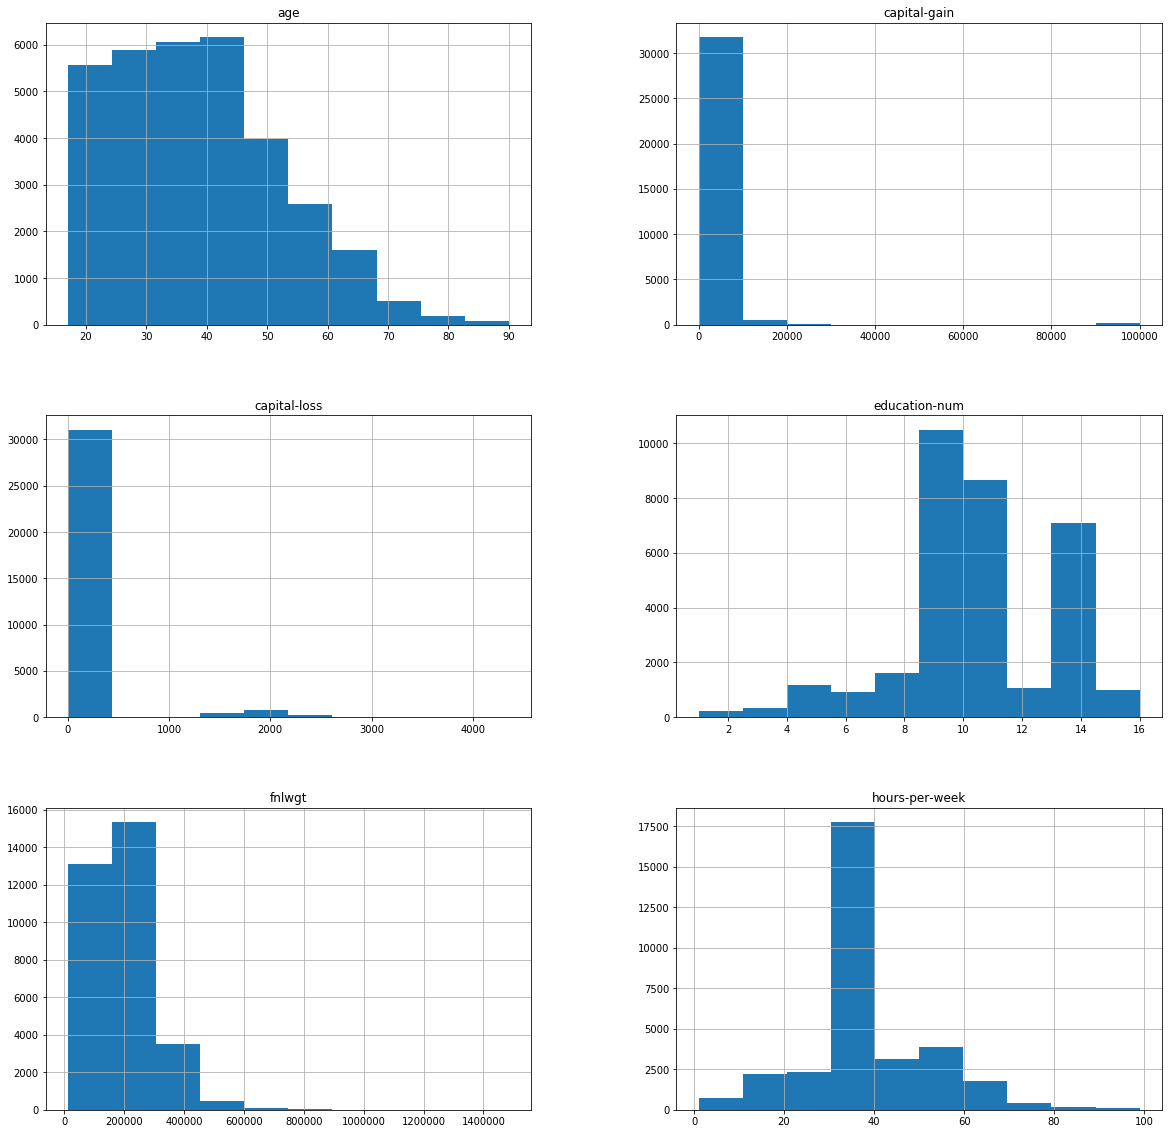

In [35]:
df.hist(figsize=(20, 20));

In [15]:
def outlier_detect_arbitrary(data,col,upper_fence,lower_fence):
    para = (upper_fence, lower_fence)
    tmp = pd.concat([data[col]>upper_fence,data[col]<lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))    
    return outlier_index, para

In [37]:
index,para = outlier_detect_arbitrary(data=df,col='capital-gain',upper_fence=50000,lower_fence=0)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 159
Доля выбросов: 0.004883142409631154
Верхняя граница: 50000 
Нижняя граница: 0


In [39]:
df.loc[index,'capital-gain'].sort_values()

1246     99999
20987    99999
21188    99999
21489    99999
21992    99999
         ...  
11976    99999
12062    99999
12093    99999
10771    99999
32518    99999
Name: capital-gain, Length: 159, dtype: int64

In [40]:
df.loc[index,'hours-per-week'].sort_values()

6035     20
7553     20
1765     20
25841    25
17644    30
         ..
24983    75
6524     80
16422    80
20283    80
23467    80
Name: hours-per-week, Length: 159, dtype: int64

In [46]:
def outlier_detect_IQR(data,col,threshold=3):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

In [48]:
index,para = outlier_detect_IQR(data=df,col='fnlwgt',threshold=5)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 25
Доля выбросов: 0.0007677896870489236
Верхняя граница: 833171.0 
Нижняя граница: -478293.0


In [49]:
def outlier_detect_mean_std(data,col,threshold=3):
    Upper_fence = data[col].mean() + threshold * data[col].std()
    Lower_fence = data[col].mean() - threshold * data[col].std()   
    para = (Upper_fence, Lower_fence)   
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

In [50]:
index,para = outlier_detect_mean_std(data=df,col='capital-loss',threshold=3)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 1470
Доля выбросов: 0.04514603359847671
Верхняя граница: 1296.1844856819584 
Нижняя граница: -1121.5768262120405


In [51]:
def outlier_detect_MAD(data,col,threshold=3.5):
    median = data[col].median()
    median_absolute_deviation = np.median([np.abs(y - median) for y in data[col]])
    modified_z_scores = pd.Series([0.6745 * (y - median) / median_absolute_deviation for y in data[col]])
    outlier_index = np.abs(modified_z_scores) > threshold
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index

In [53]:
index = outlier_detect_MAD(data=df,col='education-num',threshold=3.5)

Количество выбросов в данных: 1611
Доля выбросов: 0.04947636743343264


In [54]:
def impute_outlier_with_arbitrary(data,outlier_index,value,col=[]):
    data_copy = data.copy(deep=True)
    for i in col:
        data_copy.loc[outlier_index,i] = value
    return data_copy

In [65]:
index = outlier_detect_MAD(data=df,col='capital-gain',threshold=3.5)

Количество выбросов в данных: 2712
Доля выбросов: 0.08328982525106723


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [66]:
df2 = impute_outlier_with_arbitrary(data=df,outlier_index=index,
                                         value=-999,col=['capital-gain'])

In [67]:
df2[5:20]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,-999,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,-999,0,40,United-States,>50K
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
11,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K
12,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,<=50K
13,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,<=50K
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K


In [71]:
def impute_outlier_with_avg(data,col,outlier_index,strategy='capital-gain'):
    data_copy = data.copy(deep=True)
    if strategy=='mean':
        data_copy.loc[outlier_index,col] = data_copy[col].mean()
    elif strategy=='median':
        data_copy.loc[outlier_index,col] = data_copy[col].median()
    elif strategy=='mode':
        data_copy.loc[outlier_index,col] = data_copy[col].mode()[0]           
    return data_copy

In [72]:
df3 = impute_outlier_with_avg(data=df,col='capital-gain',
                                   outlier_index=index,strategy='mean')

In [73]:
df3[5:20]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,1077.648844,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,1077.648844,0,40,United-States,>50K
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.000000,0,80,United-States,>50K
11,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0.000000,0,40,India,>50K
12,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0.000000,0,30,United-States,<=50K
13,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0.000000,0,50,United-States,<=50K
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0.000000,0,40,?,>50K


In [77]:
X_train, X_test, y_train, y_test = train_test_split(df, df['income '], test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((26048, 15), (6513, 15))

In [78]:
ss = StandardScaler().fit(X_train[['fnlwgt']])
X_train_copy = X_train.copy(deep=True)
X_train_copy['fnlwgt_zscore'] = ss.transform(X_train_copy[['fnlwgt']])
print(X_train_copy.head(10))

       age          workclass  fnlwgt      education  education-num  \
15282   36            Private  174308           11th              7   
24870   35            Private  198202        HS-grad              9   
18822   38            Private   52963      Bachelors             13   
26404   50            Private  138270        HS-grad              9   
7842    68   Self-emp-not-inc  116903      Assoc-voc             11   
4890    51   Self-emp-not-inc  149220   Some-college             10   
3243    25            Private  206600            9th              5   
17470   19                  ?   37085   Some-college             10   
14211   34   Self-emp-not-inc   33442      Assoc-voc             11   
22453   24            Private  379418   Some-college             10   

            marital-status          occupation     relationship    race  \
15282             Divorced    Transport-moving    Not-in-family   White   
24870        Never-married     Exec-managerial    Not-in-family   Wh

In [79]:
print(X_train_copy['fnlwgt_zscore'].mean())
print(X_train_copy['fnlwgt_zscore'].std())

-1.950391800017167e-17
1.000019195884404


In [80]:
mms = MinMaxScaler().fit(X_train[['fnlwgt']])
X_train_copy = X_train.copy(deep=True)
X_train_copy['fnlwgt_minmax'] = mms.transform(X_train_copy[['fnlwgt']])
print(X_train_copy.head(5))

       age          workclass  fnlwgt   education  education-num  \
15282   36            Private  174308        11th              7   
24870   35            Private  198202     HS-grad              9   
18822   38            Private   52963   Bachelors             13   
26404   50            Private  138270     HS-grad              9   
7842    68   Self-emp-not-inc  116903   Assoc-voc             11   

            marital-status         occupation    relationship    race  \
15282             Divorced   Transport-moving   Not-in-family   White   
24870        Never-married    Exec-managerial   Not-in-family   White   
18822        Never-married       Adm-clerical   Not-in-family   White   
26404   Married-civ-spouse              Sales            Wife   Black   
7842    Married-civ-spouse     Prof-specialty         Husband   White   

           sex  capital-gain  capital-loss  hours-per-week  native-country  \
15282     Male             0             0              40   United-States

In [81]:
print(X_train_copy['fnlwgt_minmax'].max())
print(X_train_copy['fnlwgt_minmax'].min())

1.0
0.0


In [82]:
rs = RobustScaler().fit(X_train[['education-num']])
X_train_copy = X_train.copy(deep=True)
X_train_copy['education-num_robust'] = rs.transform(X_train_copy[['education-num']])
print(X_train_copy.head(6))

       age          workclass  fnlwgt      education  education-num  \
15282   36            Private  174308           11th              7   
24870   35            Private  198202        HS-grad              9   
18822   38            Private   52963      Bachelors             13   
26404   50            Private  138270        HS-grad              9   
7842    68   Self-emp-not-inc  116903      Assoc-voc             11   
4890    51   Self-emp-not-inc  149220   Some-college             10   

            marital-status         occupation    relationship    race  \
15282             Divorced   Transport-moving   Not-in-family   White   
24870        Never-married    Exec-managerial   Not-in-family   White   
18822        Never-married       Adm-clerical   Not-in-family   White   
26404   Married-civ-spouse              Sales            Wife   Black   
7842    Married-civ-spouse     Prof-specialty         Husband   White   
4890    Married-civ-spouse    Farming-fishing         Husband   

In [110]:
df_for_ohe = df
df_for_ohe = df_for_ohe.replace('>50K', 1, regex=True) 
df_for_ohe = df_for_ohe.replace('<=50K', 0, regex=True) 

df_ohe = pd.get_dummies(df_for_ohe,drop_first=True)

In [111]:
df_ohe.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
X_train, X_test, y_train, y_test = train_test_split(df_ohe.drop(labels=['income '], axis=1), 
                                                    df_ohe['income '], test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((22792, 100), (9769, 100))

In [113]:
def constant_feature_detect(data,threshold=0.98):    
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = (data_copy[feature].value_counts() / np.float(
                      len(data_copy))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature),'константные переменные')    
    return quasi_constant_feature

In [114]:
quasi_constant_feature = constant_feature_detect(data=X_train,threshold=0.9)

78 константные переменные


In [115]:
X_train['dummy'] = np.floor(X_train['capital-loss']*10)
X_train.dummy.value_counts() / np.float(len(X_train))

0.0        0.953141
19020.0    0.005835
18870.0    0.005090
19770.0    0.005046
24150.0    0.001667
             ...   
22010.0    0.000044
8100.0     0.000044
22820.0    0.000044
19440.0    0.000044
21490.0    0.000044
Name: dummy, Length: 85, dtype: float64

In [116]:
quasi_constant_feature = constant_feature_detect(data=X_train,threshold=0.9)
quasi_constant_feature

79 константные переменные


['capital-gain',
 'capital-loss',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Never-worked',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_ Without-pay',
 'education_ 11th',
 'education_ 12th',
 'education_ 1st-4th',
 'education_ 5th-6th',
 'education_ 7th-8th',
 'education_ 9th',
 'education_ Assoc-acdm',
 'education_ Assoc-voc',
 'education_ Doctorate',
 'education_ Masters',
 'education_ Preschool',
 'education_ Prof-school',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Separated',
 'marital-status_ Widowed',
 'occupation_ Armed-Forces',
 'occupation_ Farming-fishing',
 'occupation_ Handlers-cleaners',
 'occupation_ Machine-op-inspct',
 'occupation_ Priv-house-serv',
 'occupation_ Protective-serv',
 'occupation_ Tech-support',
 'occupation_ Transport-moving',
 'relationship_ Other-relative',
 'relationship_ Wife',
 'race_ Asian-Pac-Islander',
 'race_ Black',
 

In [117]:
X_train.drop(labels=quasi_constant_feature,axis=1,inplace=True)
print(X_train.shape)

(22792, 22)


In [118]:
def univariate_roc_auc(X_train,y_train,X_test,y_test,threshold):

    roc_values = []
    for feature in X_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    roc_values = pd.Series(roc_values)
    roc_values.index = X_train.columns
    print(roc_values.sort_values(ascending=False))
    print(len(roc_values[roc_values > threshold]), len(X_train.columns))
    keep_col = roc_values[roc_values > threshold]
    return keep_col

In [119]:
uni_roc_auc = univariate_roc_auc(X_train=X_train,y_train=y_train,
                                   X_test=X_test,y_test=y_test,threshold=0.8)
print(uni_roc_auc)

marital-status_ Married-civ-spouse    0.756608
education-num                         0.718415
age                                   0.710434
hours-per-week                        0.675454
marital-status_ Never-married         0.671247
sex_ Male                             0.613363
relationship_ Own-child               0.597378
relationship_ Not-in-family           0.593228
education_ Bachelors                  0.577900
occupation_ Exec-managerial           0.577210
occupation_ Prof-specialty            0.576899
education_ HS-grad                    0.571830
fnlwgt                                0.568070
occupation_ Other-service             0.553023
relationship_ Unmarried               0.550535
workclass_ Private                    0.541567
race_ White                           0.536268
occupation_ Adm-clerical              0.533235
education_ Some-college               0.532608
native-country_ United-States         0.510862
occupation_ Sales                     0.510862
occupation_ C

In [120]:
def univariate_mse(X_train,y_train,X_test,y_test,threshold):

    mse_values = []
    for feature in X_train.columns:
        clf = DecisionTreeRegressor()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict(X_test[feature].to_frame())
        mse_values.append(mean_squared_error(y_test, y_scored))
    mse_values = pd.Series(mse_values)
    mse_values.index = X_train.columns
    print(mse_values.sort_values(ascending=False))
    print(len(mse_values[mse_values > threshold]), len(X_train.columns))
    keep_col = mse_values[mse_values > threshold]
    return keep_col   

In [121]:
uni_mse = univariate_mse(X_train=X_train,y_train=y_train,
                            X_test=X_test,y_test=y_test,threshold=0.4)
print(uni_mse)

fnlwgt                                0.299998
occupation_ Craft-repair              0.183311
occupation_ Sales                     0.183180
native-country_ United-States         0.183171
education_ Some-college               0.182516
workclass_ Private                    0.182235
race_ White                           0.181878
occupation_ Adm-clerical              0.181865
education_ HS-grad                    0.180109
relationship_ Unmarried               0.179701
occupation_ Other-service             0.179163
education_ Bachelors                  0.177508
relationship_ Not-in-family           0.177271
occupation_ Prof-specialty            0.176447
occupation_ Exec-managerial           0.175898
sex_ Male                             0.175586
relationship_ Own-child               0.173611
hours-per-week                        0.169354
marital-status_ Never-married         0.165475
age                                   0.164199
education-num                         0.158024
marital-statu